# Training a `ViT` with Jax + `flax`

In [1]:
!nvcc --version
!nvidia-smi

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


Mon Apr 15 13:28:40 2024       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|


|   0  NVIDIA A100-SXM...  On   | 00000000:07:00.0 Off |                    0 |
| N/A   28C    P0    51W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+


|   1  NVIDIA A100-SXM...  On   | 00000000:46:00.0 Off |                    0 |
| N/A   30C    P0    51W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+


|   2  NVIDIA A100-SXM...  On   | 00000000:85:00.0 Off |                    0 |
| N/A   30C    P0    55W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+


|   3  NVIDIA A100-SXM...  On   | 00000000:C7:00.0 Off |                    0 |
| N/A   31C    P0    53W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                                  |
|  GPU   GI   CI        PID   Type   Process name                  GPU Memory |
|        ID   ID                                                   Usage      |
|=============================================================================|
|  No running processes found                                                 |
+-----------------------------------------------------------------------------+


In [2]:
import jax
import jax.numpy as jnp
import jax.dlpack
from jax import grad, jit, vmap, random
from jax import random
from jax.example_libraries import stax, optimizers

from tensorflow import keras
import tensorflow_datasets as tfds
import tensorflow as tf

import time
import numpy.random as npr
import math

from typing import Optional

import optax
from flax.training import train_state, checkpoints

from tqdm.auto import tqdm
from collections import defaultdict

import numpy as np

import torch
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

/soft/datascience/conda/2023-10-04/mconda3/lib/python3.10/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.12.2 when it was built against 1.12.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


## ViT

In [3]:
from rich import print
from flax import linen as nn

In [4]:
class Patches(nn.Module):
  patch_size: int
  embed_dim: int

  def setup(self):
    self.conv = nn.Conv(
        features=self.embed_dim,
        kernel_size=(self.patch_size, self.patch_size),
        strides=(self.patch_size, self.patch_size),
        padding='VALID'
    )

  def __call__(self, images):
    patches = self.conv(images)
    b, h, w, c = patches.shape
    patches = jnp.reshape(patches, (b, h*w, c))
    return patches

In [5]:
class PatchEncoder(nn.Module):
  hidden_dim: int

  @nn.compact
  def __call__(self, x):
    assert x.ndim == 3
    n, seq_len, _ = x.shape
    # Hidden dim
    x = nn.Dense(self.hidden_dim)(x)
    # Add cls token
    cls = self.param('cls_token', nn.initializers.zeros, (1, 1, self.hidden_dim))
    cls = jnp.tile(cls, (n, 1, 1))
    x = jnp.concatenate([cls, x], axis=1)
    # Add position embedding
    pos_embed = self.param(
        'position_embedding', 
        nn.initializers.normal(stddev=0.02), # From BERT
        (1, seq_len + 1, self.hidden_dim)
    )
    return x + pos_embed

In [6]:
class MultiHeadSelfAttention(nn.Module):
  hidden_dim: int
  n_heads: int
  drop_p: float

  def setup(self):
    self.q_net = nn.Dense(self.hidden_dim)
    self.k_net = nn.Dense(self.hidden_dim)
    self.v_net = nn.Dense(self.hidden_dim)

    self.proj_net = nn.Dense(self.hidden_dim)

    self.att_drop = nn.Dropout(self.drop_p)
    self.proj_drop = nn.Dropout(self.drop_p)

  def __call__(self, x, train=True):
    B, T, C = x.shape # batch_size, seq_length, hidden_dim
    N, D = self.n_heads, C // self.n_heads # num_heads, head_dim
    q = self.q_net(x).reshape(B, T, N, D).transpose(0, 2, 1, 3) # (B, N, T, D)
    k = self.k_net(x).reshape(B, T, N, D).transpose(0, 2, 1, 3)
    v = self.v_net(x).reshape(B, T, N, D).transpose(0, 2, 1, 3)

    # weights (B, N, T, T)
    weights = jnp.matmul(q, jnp.swapaxes(k, -2, -1)) / math.sqrt(D)
    normalized_weights = nn.softmax(weights, axis=-1)

    # attention (B, N, T, D)
    attention = jnp.matmul(normalized_weights, v)
    attention = self.att_drop(attention, deterministic=not train)

    # gather heads
    attention = attention.transpose(0, 2, 1, 3).reshape(B, T, N*D)

    # project
    out = self.proj_drop(self.proj_net(attention), deterministic=not train)

    return out

In [7]:
class MLP(nn.Module):
  mlp_dim: int
  drop_p: float
  out_dim: Optional[int] = None

  @nn.compact
  def __call__(self, inputs, train=True):
    actual_out_dim = inputs.shape[-1] if self.out_dim is None else self.out_dim
    x = nn.Dense(features=self.mlp_dim)(inputs)
    x = nn.gelu(x)
    x = nn.Dropout(rate=self.drop_p, deterministic=not train)(x)
    x = nn.Dense(features=actual_out_dim)(x)
    x = nn.Dropout(rate=self.drop_p, deterministic=not train)(x)
    return x

In [8]:
class TransformerEncoder(nn.Module):
  embed_dim: int
  hidden_dim: int
  n_heads: int
  drop_p: float
  mlp_dim: int

  def setup(self):
    self.mha = MultiHeadSelfAttention(self.hidden_dim, self.n_heads, self.drop_p)
    self.mlp = MLP(self.mlp_dim, self.drop_p)
    self.layer_norm = nn.LayerNorm(epsilon=1e-6)
  
  def __call__(self, inputs, train=True):
    # Attention Block
    x = self.layer_norm(inputs)
    x = self.mha(x, train)
    x = inputs + x
    # MLP block
    y = self.layer_norm(x)
    y = self.mlp(y, train)

    return x + y

In [9]:
class ViT(nn.Module):
  patch_size: int
  embed_dim: int
  hidden_dim: int
  n_heads: int
  drop_p: float
  num_layers: int
  mlp_dim: int
  num_classes: int

  def setup(self):
    self.patch_extracter = Patches(self.patch_size, self.embed_dim)
    self.patch_encoder = PatchEncoder(self.hidden_dim)
    self.dropout = nn.Dropout(self.drop_p)
    self.transformer_blocks = [
      TransformerEncoder(self.embed_dim, self.hidden_dim, self.n_heads, self.drop_p, self.mlp_dim)
      for _ in range(self.num_layers)]
    self.cls_head = nn.Dense(features=self.num_classes)

  def __call__(self, x, train=True):
    x = self.patch_extracter(x)
    x = self.patch_encoder(x)
    x = self.dropout(x, deterministic=not train)
    for block in self.transformer_blocks:
      x = block(x, train)
    # MLP head
    x = x[:, 0] # [CLS] token
    x = self.cls_head(x)
    return x

## Hyper-parameters

In [10]:
IMAGE_SIZE = 32
BATCH_SIZE = 128
DATA_MEANS = np.array([0.49139968, 0.48215841, 0.44653091])
DATA_STD = np.array([0.24703223, 0.24348513, 0.26158784])
CROP_SCALES = (0.8, 1.0)
CROP_RATIO = (0.9, 1.1)
SEED = 42

## Dataset preparation(torchvision)

In [11]:
import torchvision
from torchvision import transforms
from torchvision.datasets import CIFAR10

In [12]:
def image_to_numpy(img):
  img = np.array(img, dtype=np.float32)
  img = (img / 255. - DATA_MEANS) / DATA_STD
  return img

In [13]:
# We need to stack the batch elements
def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple, list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

In [14]:
test_transform = image_to_numpy
# For training, we add some augmentations. Neworks are too powerful and would overfit.
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE), scale=CROP_SCALES, ratio=CROP_RATIO),
    image_to_numpy
])

# Validation set should not use the augmentation.
train_dataset = CIFAR10('data', train=True, transform=train_transform, download=True)
val_dataset = CIFAR10('data', train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(SEED))
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(SEED))
test_set = CIFAR10('data', train=False, transform=test_transform, download=True)

train_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2, persistent_workers=True, collate_fn=numpy_collate,
)
val_loader = torch.utils.data.DataLoader(
    val_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=2, persistent_workers=True, collate_fn=numpy_collate,
)
test_loader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=2, persistent_workers=True, collate_fn=numpy_collate,
)

  0%|          | 0/170498071 [00:00<?, ?it/s]

  2%|▏         | 4030464/170498071 [00:00<00:04, 40254963.18it/s]

  7%|▋         | 11796480/170498071 [00:00<00:02, 62122529.41it/s]

 12%|█▏        | 21200896/170498071 [00:00<00:01, 76611162.47it/s]

 17%|█▋        | 29130752/170498071 [00:00<00:01, 77656324.89it/s]

 22%|██▏       | 38141952/170498071 [00:00<00:01, 82101850.36it/s]

 27%|██▋       | 46366720/170498071 [00:00<00:01, 80639557.65it/s]

 33%|███▎      | 55738368/170498071 [00:00<00:01, 84828300.23it/s]

 38%|███▊      | 64258048/170498071 [00:00<00:01, 81847654.03it/s]

 43%|████▎     | 73957376/170498071 [00:00<00:01, 86412395.66it/s]

 48%|████▊     | 82640896/170498071 [00:01<00:01, 81945050.88it/s]

 54%|█████▍    | 92176384/170498071 [00:01<00:00, 85618074.62it/s]

 59%|█████▉    | 100827136/170498071 [00:01<00:00, 82720802.73it/s]

 65%|██████▍   | 110133248/170498071 [00:01<00:00, 85559789.11it/s]

 70%|██████▉   | 118751232/170498071 [00:01<00:00, 83517699.83it/s]

 75%|███████▍  | 127795200/170498071 [00:01<00:00, 85509039.91it/s]

 80%|████████  | 136413184/170498071 [00:01<00:00, 83015663.94it/s]

 85%|████████▌ | 145293312/170498071 [00:01<00:00, 84570325.84it/s]

 90%|█████████ | 153812992/170498071 [00:01<00:00, 83067462.68it/s]

 95%|█████████▌| 162562048/170498071 [00:01<00:00, 84173560.55it/s]

100%|██████████| 170498071/170498071 [00:02<00:00, 81961717.75it/s]

Extracting data/cifar-10-python.tar.gz to data


Files already downloaded and verified


Files already downloaded and verified


In [15]:
batch = next(iter(train_loader))
print(f'image: {batch[0].shape}, label: {batch[1].shape}')
print(f'type batch[0]: {type(batch[0])}, batch[1]: {type(batch[1])}')

image: (128, 32, 32, 3), label: (128,)

type batch[0]: <class 'numpy.ndarray'>, batch[1]: <class 'numpy.ndarray'>

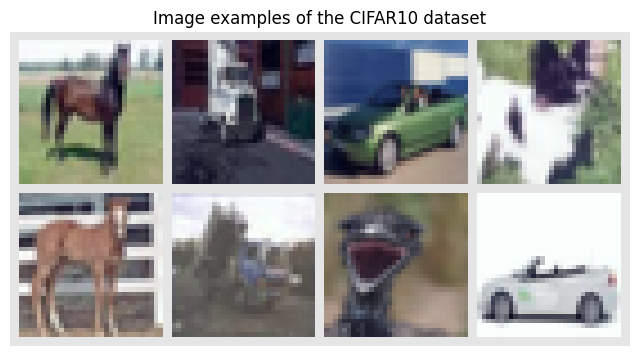

In [16]:
# Visualize some examples
def numpy_to_torch(array):
  array = jax.device_get(array)
  tensor = torch.from_numpy(array)
  tensor = tensor.permute(0, 3, 1, 2)
  return tensor

NUM_IMAGES = 8
CIFAR_images = np.stack([val_set[idx][0] for idx in range(NUM_IMAGES)], axis=0)
img_grid = torchvision.utils.make_grid(numpy_to_torch(CIFAR_images), nrow=4, normalize=True, pad_value=0.9)
img_grid = img_grid.permute(1, 2, 0)

plt.figure(figsize=(8,8))
plt.title("Image examples of the CIFAR10 dataset")
plt.imshow(img_grid)
plt.axis('off')
plt.show()
plt.close()

## Initialize model

In [17]:
def initialize_model(
    seed=42,
    patch_size=4, embed_dim=64, hidden_dim=192,
    n_heads=3, drop_p=0.1, num_layers=12, mlp_dim=768, num_classes=10
):
  main_rng = jax.random.PRNGKey(seed)
  x = jnp.ones(shape=(5, 32, 32, 3))
  # ViT
  model = ViT(
      patch_size=patch_size,
      embed_dim=embed_dim,
      hidden_dim=hidden_dim,
      n_heads=n_heads,
      drop_p=drop_p,
      num_layers=num_layers,
      mlp_dim=mlp_dim,
      num_classes=num_classes
  )
  main_rng, init_rng, drop_rng = random.split(main_rng, 3)
  params = model.init({'params': init_rng, 'dropout': drop_rng}, x, train=True)['params']
  return model, params, main_rng

In [18]:
vit_model, vit_params, vit_rng = initialize_model()

In [19]:
jax.tree_map(lambda x: x.shape, vit_params)

{'cls_head': {'bias': (10,), 'kernel': (192, 10)},
 'patch_encoder': {'Dense_0': {'bias': (192,), 'kernel': (64, 192)},
  'cls_token': (1, 1, 192),
  'position_embedding': (1, 65, 192)},
 'patch_extracter': {'conv': {'bias': (64,), 'kernel': (4, 4, 3, 64)}},
 'transformer_blocks_0': {'layer_norm': {'bias': (192,), 'scale': (192,)},
  'mha': {'k_net': {'bias': (192,), 'kernel': (192, 192)},
   'proj_net': {'bias': (192,), 'kernel': (192, 192)},
   'q_net': {'bias': (192,), 'kernel': (192, 192)},
   'v_net': {'bias': (192,), 'kernel': (192, 192)}},
  'mlp': {'Dense_0': {'bias': (768,), 'kernel': (192, 768)},
   'Dense_1': {'bias': (192,), 'kernel': (768, 192)}}},
 'transformer_blocks_1': {'layer_norm': {'bias': (192,), 'scale': (192,)},
  'mha': {'k_net': {'bias': (192,), 'kernel': (192, 192)},
   'proj_net': {'bias': (192,), 'kernel': (192, 192)},
   'q_net': {'bias': (192,), 'kernel': (192, 192)},
   'v_net': {'bias': (192,), 'kernel': (192, 192)}},
  'mlp': {'Dense_0': {'bias': (768,)

## Define loss

In [20]:
def calculate_loss(params, state, rng, batch, train):
  imgs, labels = batch
  rng, drop_rng = random.split(rng)
  logits = state.apply_fn({'params': params}, imgs, train=train, rngs={'dropout': drop_rng})
  loss = optax.softmax_cross_entropy_with_integer_labels(logits=logits, labels=labels).mean()
  acc = (logits.argmax(axis=-1) == labels).mean()
  return loss, (acc, rng)

## Train step

In [21]:
@jax.jit
def train_step(state, rng, batch):
  loss_fn = lambda params: calculate_loss(params, state, rng, batch, train=True)
  # Get loss, gradients for loss, and other outputs of loss function
  (loss, (acc, rng)), grads = jax.value_and_grad(loss_fn, has_aux=True)(state.params)
  # Update parameters and batch statistics
  state = state.apply_gradients(grads=grads)
  return state, rng, loss, acc

## Evaluate step

In [22]:
@jax.jit
def eval_step(state, rng, batch):
  _, (acc, rng) = calculate_loss(state.params, state, rng, batch, train=False)
  return rng, acc

In [23]:
logger = SummaryWriter(log_dir='vit_jax_logs')

## Train function

In [24]:
def train_epoch(train_loader, epoch_idx, state, rng):
  metrics = defaultdict(list)
  for batch in tqdm(train_loader, desc='Training', leave=False):
    state, rng, loss, acc = train_step(state, rng, batch)
    metrics['loss'].append(loss)
    metrics['acc'].append(acc)
  for key in metrics.keys():
    arg_val = np.stack(jax.device_get(metrics[key])).mean()
    logger.add_scalar('train/' + key, arg_val, global_step=epoch_idx)
    print(f'[epoch {epoch_idx}] {key}: {arg_val}')
  return state, rng

## Evaluate function

In [25]:
def eval_model(data_loader, state, rng):
  # Test model on all images of a data loader and return avg loss
  correct_class, count = 0, 0
  for batch in data_loader:
    rng, acc = eval_step(state, rng, batch)
    correct_class += acc * batch[0].shape[0]
    count += batch[0].shape[0]
  eval_acc = (correct_class / count).item()
  return eval_acc

## Train model

In [26]:
def train_model(train_loader, val_loader, state, rng, num_epochs=100):
  best_eval = 0.0
  for epoch_idx in tqdm(range(1, num_epochs + 1)):
    state, rng = train_epoch(train_loader, epoch_idx, state, rng)
    if epoch_idx % 1 == 0:
      eval_acc = eval_model(val_loader, state, rng)
      logger.add_scalar('val/acc', eval_acc, global_step=epoch_idx)
      if eval_acc >= best_eval:
        best_eval = eval_acc
        save_model(state, step=epoch_idx)
      logger.flush()
  # Evaluate after training
  test_acc = eval_model(test_loader, state, rng)
  print(f'test_acc: {test_acc}')

## Create train state

In [27]:
def create_train_state(
    model, params, learning_rate
):
  optimizer = optax.adam(learning_rate)
  return train_state.TrainState.create(
      apply_fn=model.apply,
      tx=optimizer,
      params=params
  )

## Save model

In [28]:
def save_model(state, step=0):
  checkpoints.save_checkpoint(ckpt_dir='vit_jax_logs', target=state.params, step=step, overwrite=True)

## Training

In [29]:
state = create_train_state(vit_model, vit_params, 3e-4)

In [30]:
train_model(train_loader, val_loader, state, vit_rng, num_epochs=100)

  0%|          | 0/100 [00:00<?, ?it/s]

Training:   0%|          | 0/351 [00:00<?, ?it/s]

loss: 2.336591958999634

acc: 0.28269675374031067

Training:   0%|          | 0/351 [00:00<?, ?it/s]

loss: 1.7297300100326538

acc: 0.377225786447525

Training:   0%|          | 0/351 [00:00<?, ?it/s]

loss: 1.5610712766647339

acc: 0.43678775429725647

Training:   0%|          | 0/351 [00:00<?, ?it/s]

loss: 1.4541274309158325

acc: 0.47320157289505005

Training:   0%|          | 0/351 [00:00<?, ?it/s]

loss: 1.356857419013977

acc: 0.5102831125259399

Training:   0%|          | 0/351 [00:00<?, ?it/s]

loss: 1.2777398824691772

acc: 0.5418002009391785

Training:   0%|          | 0/351 [00:00<?, ?it/s]

loss: 1.209302544593811

acc: 0.5626558065414429

Training:   0%|          | 0/351 [00:00<?, ?it/s]

loss: 1.169034719467163

acc: 0.5769230723381042

Training:   0%|          | 0/351 [00:00<?, ?it/s]

loss: 1.1179755926132202

acc: 0.5989360809326172

Training:   0%|          | 0/351 [00:00<?, ?it/s]

loss: 1.06916344165802

acc: 0.6181890964508057

Training:   0%|          | 0/351 [00:00<?, ?it/s]

loss: 1.0425459146499634

acc: 0.6272035241127014

Training:   0%|          | 0/351 [00:00<?, ?it/s]

loss: 1.0012234449386597

acc: 0.6396234035491943

Training:   0%|          | 0/351 [00:00<?, ?it/s]

loss: 0.9687538146972656

acc: 0.6524661779403687

Training:   0%|          | 0/351 [00:00<?, ?it/s]

loss: 0.9474165439605713

acc: 0.6617031693458557

Training:   0%|          | 0/351 [00:00<?, ?it/s]

loss: 0.9081081748008728

acc: 0.6773949265480042

Training:   0%|          | 0/351 [00:00<?, ?it/s]

2024-04-15 13:34:32.071264: W external/xla/xla/service/gpu/runtime/support.cc:58] Intercepted XLA runtime error:
INTERNAL: Failed to update gpu graph: Graph update result=kNodeTypeChanged: Failed to update CUDA graph: CUDA_ERROR_GRAPH_EXEC_UPDATE_FAILURE: the graph update was not performed because it included changes which violated constraints specific to instantiated graph update
2024-04-15 13:34:32.071508: E external/xla/xla/pjrt/pjrt_stream_executor_client.cc:2711] Execution of replica 0 failed: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.graph.launch' failed: Failed to update gpu graph: Graph update result=kNodeTypeChanged: Failed to update CUDA graph: CUDA_ERROR_GRAPH_EXEC_UPDATE_FAILURE: the graph update was not performed because it included changes which violated constraints specific to instantiated graph update; current profiling annotation: XlaModule:#hlo_module=jit_train_step,program_id=105#.


ValueError: INTERNAL: Failed to execute XLA Runtime executable: run time error: custom call 'xla.gpu.graph.launch' failed: Failed to update gpu graph: Graph update result=kNodeTypeChanged: Failed to update CUDA graph: CUDA_ERROR_GRAPH_EXEC_UPDATE_FAILURE: the graph update was not performed because it included changes which violated constraints specific to instantiated graph update; current profiling annotation: XlaModule:#hlo_module=jit_train_step,program_id=105#.